In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics
import re 
from operator import itemgetter
import warnings
from scipy.integrate import solve_ivp
from scipy import optimize
import seaborn as sns
import PyCCELL_PRFQT as px
from sklearn.metrics import r2_score
warnings.filterwarnings('ignore')

![../images/master_eq_model.png](../images/master_eq_model.png)

# Load the data

In [186]:
# load
correct = px.mainf('../results/SHERLOCK/target_concentration/sherlock_target_concentr.xlsx'
               ,70,"YES",'col',['K16','L16','M16'])

# Rename the columns

correct.rename(columns={"['H9', 'I9', 'J9']": '10µM_FITC',
                   "['H10', 'I10', 'J10']": '5µM_FITC',
                     "['H11', 'I11', 'J11']":'2µM_FITC' ,
                     "['H12', 'I12', 'J12']": '1µM_FITC',
                    "['H13', 'I13', 'J13']": '0.1µM_FITC',
                      "['H14', 'I14', 'J14']":'0.01µM_FITC' ,
                     "['H15', 'I15', 'J15']": '0.001µM_FITC',
                    "['H16', 'I16', 'J16']": 'NC_FITC',
                     "['K9', 'L9', 'M9']": '1µM_target',
                   "['K10', 'L10', 'M10']": '0.1µM_target',
                     "['K11', 'L11', 'M11']":'0.01µM_target' ,
                     "['K12', 'L12', 'M12']": '1nM_target',
                    "['K13', 'L13', 'M13']": '0.1nM_target',
                      "['K14', 'L14', 'M14']":'0.01nM_target' ,
                     "['K15', 'L15', 'M15']": '0.1pM_target',
                    "['K16', 'L16', 'M16']": 'NC_target',
                     0: '10µM_FITC_std',
                   1: '1µM_target_std',
                     2: '5µM_FITC_std',
                     3: '0.1µM_target_std',
                    4: '2µM_FITC_std',
                    5: '0.01µM_target_std',
                   6: '1µM_FITC_std',
                     7:'1nM_target_std' ,
                     8: '0.1µM_FITC_std',
                    9: '0.1nM_target_std',
                    10: '0.01µM_FITC_std',
                   11: '0.01nM_target_std',
                     12: '1nM_FITC_std',
                     13: '0.1pM_target_std',
                    14: 'NC_FITC_std',
                    15:'NC_target_std'},
          inplace=True, errors='raise')

correct.head()

,10µM_FITC,1µM_target,5µM_FITC,0.1µM_target,2µM_FITC,0.01µM_target,1µM_FITC,1nM_target,0.1µM_FITC,0.1nM_target,...,1µM_FITC_std,1nM_target_std,0.1µM_FITC_std,0.1nM_target_std,0.01µM_FITC_std,0.01nM_target_std,1nM_FITC_std,0.1pM_target_std,NC_FITC_std,NC_target_std
0,9.697937,0.055873,4.803333,0.000000,1.954603,0.009841,1.135397,0.0,0.391905,0.0,...,0.136073,0.244756,0.082644,0.091951,0.058089,0.056878,0.054902,0.007866,0.014142,0.011208
1,8.678571,0.388095,4.078571,0.000000,1.334603,0.000000,0.628889,0.0,0.000000,0.0,...,0.133369,0.726438,0.038502,0.847473,0.063122,0.623463,0.079329,0.866017,0.084873,0.758101
2,12.689206,1.199524,6.717937,0.078254,2.983651,0.000000,1.790794,0.0,1.228095,0.0,...,0.394305,0.336887,0.207361,0.194752,0.291521,0.172988,0.148309,0.156005,0.152101,0.185042
3,12.426984,2.635714,6.500952,0.618413,2.926667,0.000000,2.038095,0.0,1.305397,0.0,...,0.161015,0.335035,0.191609,0.177314,0.119023,0.159265,0.179541,0.169277,0.108229,0.262830
4,12.210159,3.302222,6.296508,1.371587,2.918889,0.000000,2.135079,0.0,1.412381,0.0,...,0.173781,0.338014,0.228196,0.181659,0.113460,0.053356,0.216622,0.189353,0.135465,0.251958


# Define the model

In [3]:

def system(t,z,param):
    
    GC,GCT,Pa,Pi,Tc,Tu= z
    
    k1,k3,k4 = param  
    
    dGCdt = -(k1*GC*Tu) + k4 * GCT
    
    dGCTdt = - dGCdt
    
    dPadt = k3*GCT*Pi

    dPidt = -dPadt
    
    dTcdt = k4*GCT
    
    dTudt = -(k1*GC*Tu)
    
    return [dGCdt, dGCTdt, dPadt, dPidt, dTcdt, dTudt]

def error(param,obs):
    
    times = np.linspace(0,480,97)
    
    t = np.linspace(0,500,500)
    
    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([param]),
                    t_eval=times,method='DOP853',dense_output=True,rtol=1e-8,atol=1e-8)
    
    m = sol.sol(times)
    
    err = []
        
    for i in range(len(m.tolist()[2])): #don't forget that the [2] is because we are fitting the dPadt 
        err.append((obs[i]-m.tolist()[2][i])**2)  
        
    
    erro = np.sum(err)

    return erro

## Fit the data by adjusting the parameters by hand

In [4]:
#Initial conditions (concentrations in microM)
GC0 = 0.4 
GCT0 = 0.
Pa0 = 0.
Pi0 = 4.5
Tc0 = 0.
Tu0 = 1

# Parameters (in /min)
k1 = 1
k3 = 0.15
k4 = 0.01


z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
param  = [k1,k3,k4]

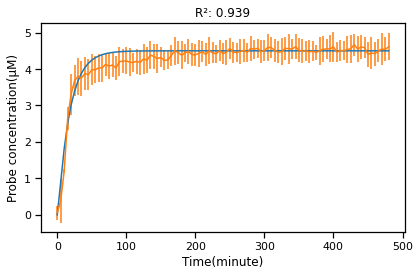

In [14]:
times = np.linspace(0,480,97)

sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([param]),
                    t_eval=times,dense_output=True)
m = sol.sol(times)
r = r2_score(correct[correct.columns[1]],m[2])


sns.set_context('notebook')
sns.set_palette("tab10")

plt.plot(times,m[2])
plt.errorbar(times,correct[correct.columns[1]],yerr=correct['1nM_target_std'])
plt.xlabel('Time(minute)')
plt.ylabel('Probe concentration(µM)')
plt.title('R²: '+str(round(r,3)))
plt.tight_layout()
#plt.xlim(50,480)
#plt.savefig("images/SHERLOCK/modeling/first_attempt.png",dpi=300)
plt.show()

## With minimization

In [20]:
#Initial conditions (concentrations in microM)
GC0 = 0.4 
GCT0 = 0.
Pa0 = 0.
Pi0 = 4.5
Tc0 = 0.
Tu0 = 1

# Parameters (in /min)
k1 = 1
k3 = 0.15
k4 = 0.01


z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
param  = [k1,k3,k4]

bnds = [(0.0001,1),(10,1000),(0.003,3)]
res = optimize.minimize(error, param, args=(list(correct[correct.columns[3]])),method='Nelder-Mead')#,bounds=bnds)#

In [21]:
res.x

array([0.02248105, 0.51590274, 0.12765232])

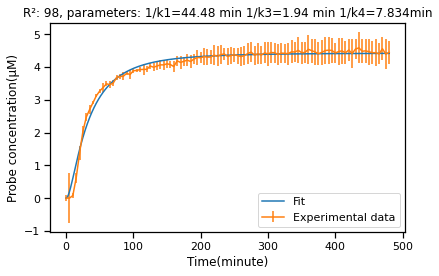

In [22]:
#times = np.linspace(0,480,97)
times = np.linspace(0,480,97*3-1)
times_exp = np.linspace(0,480,97)

sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                	t_eval=times,dense_output=True)
m = sol.sol(times)

## 
counter = 0
cleaned_m = []
for val in m[2]:
    if counter%3 == 0:
        cleaned_m.append(val)
    counter +=1
    
#r = r2_score(correct[correct.columns[1]],m[2])
r = r2_score(correct[correct.columns[3]],cleaned_m)


sns.set_context('notebook')
#sns.set_palette("tab10")

plt.plot(times,m[2],label="Fit")
plt.errorbar(times_exp,correct[correct.columns[3]],label="Experimental data",yerr=correct['0.1nM_target_std'])
plt.xlabel('Time(minute)')
plt.ylabel('Probe concentration(µM)')
plt.title(f'R²: {(round(r*100))}, parameters: 1/k1={round(1/res.x[0],2)} min 1/k3={round(1/res.x[1],2)} min 1/k4={round(1/res.x[2],3)}min')
plt.tight_layout()
plt.legend()
#plt.xlim(0,50)
#plt.savefig("../images/SHERLOCK/modeling/better_model.png",dpi=300)
#plt.savefig("../images/fixed_model.png",dpi=300)
plt.show()

# Plot all the species in the model

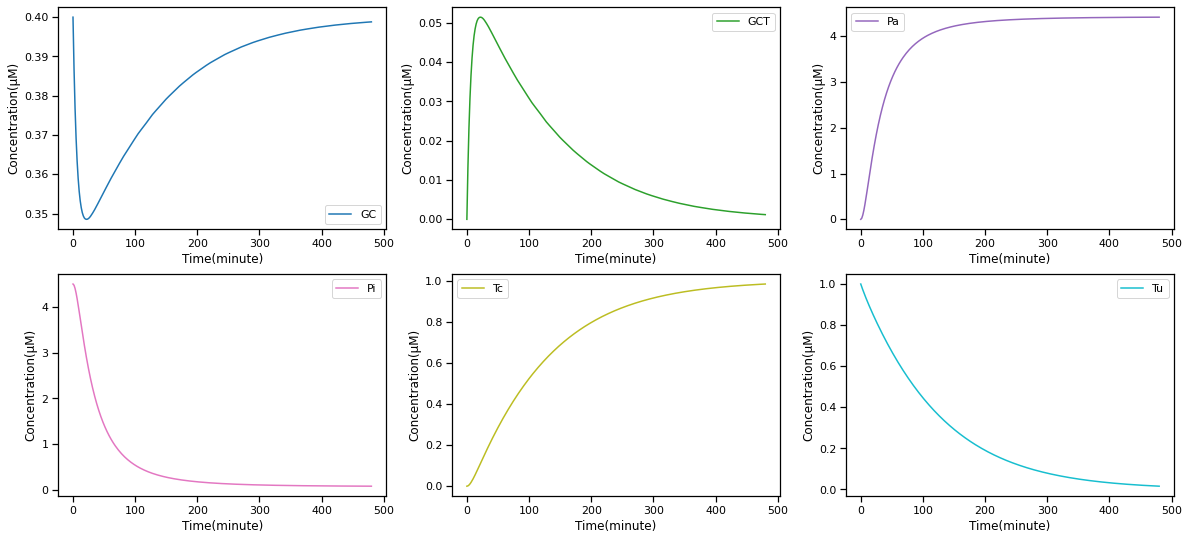

In [23]:
fig,ax = plt.subplots(2,3)
fig.set_size_inches(20,9)

def get_cmap(n, name='tab10'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(6)

counter=0
name = ["GC",'GCT',"Pa","Pi","Tc","Tu"]
for r in range(2):
    for c in range(3):
        ax[r,c].plot(times,m[counter],label=name[counter],c=cmap(counter))
        ax[r,c].set_xlabel('Time(minute)')
        ax[r,c].set_ylabel('Concentration(µM)')
        ax[r,c].legend()
        ax[r,c].ticklabel_format(useOffset=False)
        #ax[r,c].set_xlim(0,75)
        counter += 1
    
#plt.savefig("../images/SHERLOCK/modeling/all_species.png",dpi=300)
plt.savefig("all_species.png",dpi=300)
plt.show()

# Test different target concentration

In [188]:
correct.columns

Index(['10µM_FITC', '1µM_target', '5µM_FITC', '0.1µM_target', '2µM_FITC',
       '0.01µM_target', '1µM_FITC', '1nM_target', '0.1µM_FITC', '0.1nM_target',
       '0.01µM_FITC', '0.01nM_target', '0.001µM_FITC', '0.1pM_target',
       'NC_FITC', 'NC_target', 'Time', '10µM_FITC_std', '1µM_target_std',
       '5µM_FITC_std', '0.1µM_target_std', '2µM_FITC_std', '0.01µM_target_std',
       '1µM_FITC_std', '1nM_target_std', '0.1µM_FITC_std', '0.1nM_target_std',
       '0.01µM_FITC_std', '0.01nM_target_std', '1nM_FITC_std',
       '0.1pM_target_std', 'NC_FITC_std', 'NC_target_std'],
      dtype='object')

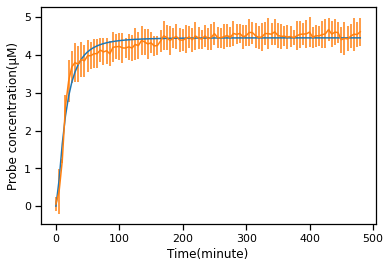

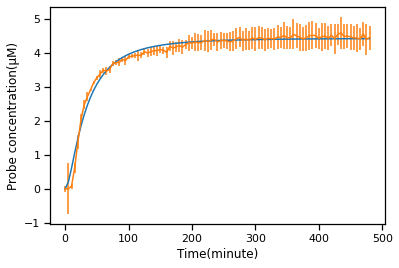

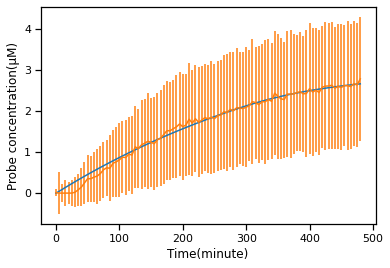

In [195]:
constants = pd.DataFrame()
for i,j in zip([1,3,5],['1µM_target_std','0.1µM_target_std','0.01µM_target_std']):
    res = optimize.minimize(error, param, args=(list(correct[correct.columns[i]])),method='Nelder-Mead')
    times = np.linspace(0,480,97)

    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)
    k1,k2,k3 = res.x[0],res.x[1],res.x[2]
    
    constants[j.strip('std')] = [k1,k2,k3]
    
    r = r2_score(correct[correct.columns[i]],m[2])

    plt.plot(times,m[2],label="Fit")
    plt.errorbar(times_exp,correct[correct.columns[i]],label="Experimental data",yerr=correct[j])
    plt.xlabel('Time(minute)')
    plt.ylabel('Probe concentration(µM)')
    #plt.title(f'R²: {(round(r*100))}, parameters: 1/k1={round(1/res.x[0],2)} min 1/k3={round(1/res.x[1],2)} min 1/k4={round(1/res.x[2],3)}min')
    #plt.legend()
    plt.show()

constants = constants.rename({0: 'k1', 1: 'k3',2:'k4'}, axis='index')



In [229]:
constants

,1µM_target_,0.1µM_target_,0.01µM_target_
k1,0.044815,0.022481,2.405473
k3,1.217653,0.515903,0.005384
k4,0.269283,0.127652,0.005047


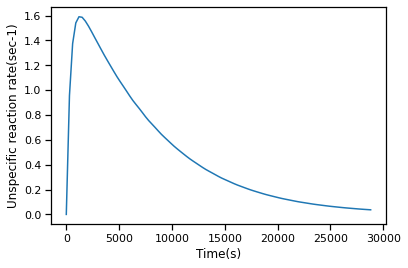

In [254]:
times = np.linspace(0,480,97)

sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([constants['0.1µM_target_']]),
                    t_eval=times,dense_output=True)
m = sol.sol(times)

    
k = [] # list that will contain all the value of k3

'''
K3 depends on the concentration of Pi to compute it's value
I multiply each value of Pi by the value obtained for k3
by the minimization
m[3] is the solution of the system of ODE for Pi
constants is the dataframe where I stored all the values of k
k_s is a list of value of k but in seconds-1 (min-1 * 60)
I then plot the value of k3 as a function of the concentration of inactive probe
'''

for i in range(len(m[3])): 
    k.append(constants.iloc[1].values[1]*m[1][i])#*m[1][i])
    
k_s = [x*60 for x in k ] 
times_s = [x*60 for x in times]

#plt.plot(m[3],k_s) # the slope should be the value of k3 (verified)
plt.plot(times_s,k_s)
#plt.xlabel("[Pa] (µM)")
plt.ylabel("Unspecific reaction rate(sec-1)")
plt.xlabel('Time(s)')
plt.savefig('../images/SHERLOCK/modeling/reaction_rate_poc.png',dpi=300)
plt.show()

In [243]:
def constant(t,k,p):
    if k == 1:
        f,l,label = 5,0,'Cas-target binding rate (sec-1)'
    else:
        f,l,label = 3,1,"Unspecific reaction rate (sec-1)"
    
    times = np.linspace(0,480,97)
    times_s = [x*60 for x in times]

    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([constants[t]]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)

    k = [] # list that will contain all the value of k3

    for i in range(len(m[f])): 
        k.append(constants.iloc[l].values[p]*m[f][i])

    k_s = [x*60 for x in k ]

    plt.plot(times_s,k_s)
    plt.xlabel("Time (sec)")
    plt.ylabel(label)
    #plt.show()

#const('1nM_target_',1)

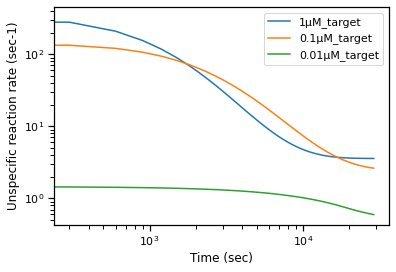

In [246]:
for i,j in zip(constants.columns,range(3)):
    constant(i,3,j)

legend = [x.strip('_') for x in constants.columns]

plt.legend(legend)

plt.yscale('log')
plt.xscale('log')
#plt.savefig('../images/SHERLOCK/modeling/catalytic_rates_log.png',dpi=300)
plt.show()

times_s = [x*60 for x in times]
plt.plot(times_s,k_s)
plt.xlabel('Time(s)')
plt.ylabel('Unspecific catalytic rate(sec-1)')
plt.show()

times = np.linspace(0,480,97)

sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([constants['1nM_target_']]),
                    t_eval=times,dense_output=True)
m = sol.sol(times)

    
k = [] # list that will contain all the value of k3

'''
K3 depends on the concentration of Pi to compute it's value
I multiply each value of Pi by the value obtained for k3
by the minimization
m[3] is the solution of the system of ODE for Pi
constants is the dataframe where I stored all the values of k
k_s is a list of value of k but in seconds-1 (min-1 * 60)
I then plot the value of k3 as a function of the concentration of inactive probe
'''

for i in range(len(m[3])): 
    k.append(constants.iloc[0].values[0]*m[5][i])
    
k_s = [x*60 for x in k ]

plt.plot(m[5],k_s)
plt.xlabel("[Pa] (µM)")
plt.ylabel("Cas-target binding rate(sec-1)")
plt.show()

plt.plot(times,k)
plt.xlabel('Time(minutes)')
plt.ylabel('Cas-target binding rate(sec-1)')
plt.show()

# Fit individual experimental curves

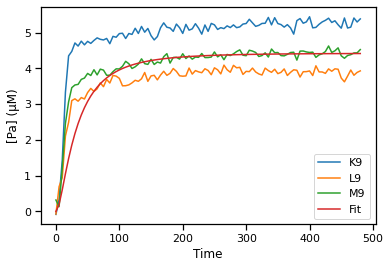

In [204]:
df = px.excelreader('../results/SHERLOCK/target_concentration/sherlock_target_concentr.xlsx'
               ,70,"YES")
for i,j in zip(['K9','L9','M9'],['K16','L16','M16']):
    df[i] = df[i] - df[j]

df[['K9','L9','M9','Time']].plot(x='Time')
plt.plot(times,m[2],label="Fit")
plt.ylabel("[Pa] (µM)")
plt.legend()
plt.show()

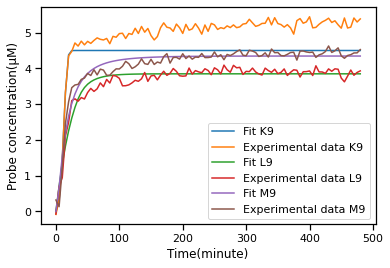

In [227]:
const = pd.DataFrame()
for i in ['K9','L9','M9']:
    res = optimize.minimize(error, param, args=(list(df[i])),method='Nelder-Mead')
    times = np.linspace(0,480,97)

    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)
    k1,k2,k3 = res.x[0],res.x[1],res.x[2]
    
    const[i] = [k1,k2,k3]
    
    r = r2_score(df[i],m[2])

    plt.plot(times,m[2],label="Fit "+ str(i))
    plt.plot(times,df[i],label="Experimental data "+str(i))
    plt.xlabel('Time(minute)')
    plt.ylabel('Probe concentration(µM)')
    #plt.title(f'R²: {(round(r*100))}, parameters: 1/k1={round(1/res.x[0],2)} min 1/k3={round(1/res.x[1],2)} min 1/k4={round(1/res.x[2],3)}min')
    plt.legend()
    #plt.show()

const = const.rename({0: 'k1', 1: 'k3',2:'k4'}, axis='index')

plt.savefig('../images/SHERLOCK/modeling/fitting_individual_curves.png',dpi=300)

In [209]:
const

,K9,L9,M9
k1,0.058937,7.950303,0.049948
k3,0.178061,0.088840,1.191031
k4,-0.231057,0.045989,0.353594


In [247]:
def constante(t,k,p):
    if k == 1:
        f,l,label = 5,0,'Cas-target binding rate (sec-1)'
    else:
        f,l,label = 3,1,"Unspecific reaction rate (sec-1)"
    
    times = np.linspace(0,480,97)
    times_s = [x*60 for x in times]

    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([const[t]]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)

    k = [] # list that will contain all the value of k3

    for i in range(len(m[f])): 
        k.append(const.iloc[l].values[p]*m[f][i])

    k_s = [x*60 for x in k ]

    plt.plot(times_s,k_s)
    plt.xlabel("Time (sec)")
    plt.ylabel(label)
    #plt.show()

#const('1nM_target_',1)

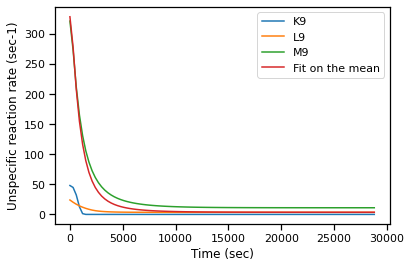

In [250]:
for i,j in zip(const.columns,range(3)):
    constante(i,3,j)

legend = [x for x in const.columns]
legend.append("Fit on the mean")

constant(constants.columns[0],3,0)

plt.legend(legend)

#plt.yscale('log')
#plt.xscale('log')
#plt.savefig('../images/SHERLOCK/modeling/catalytic_rates_individual_curves.png',dpi=300)
plt.show()

## Test multiple gain

correct = px.mainf('../results/SHERLOCK/target_concentration/sherlock_target_concentr.xlsx'
               ,50,"YES",'col',['K16','L16','M16'])

correct.rename(columns={"['H9', 'I9', 'J9']": '10µM_FITC',
                   "['H10', 'I10', 'J10']": '5µM_FITC',
                     "['H11', 'I11', 'J11']":'2µM_FITC' ,
                     "['H12', 'I12', 'J12']": '1µM_FITC',
                    "['H13', 'I13', 'J13']": '0.1µM_FITC',
                      "['H14', 'I14', 'J14']":'0.01µM_FITC' ,
                     "['H15', 'I15', 'J15']": '0.001µM_FITC',
                    "['H16', 'I16', 'J16']": 'NC_FITC',
                     "['K9', 'L9', 'M9']": '1nM_target',
                   "['K10', 'L10', 'M10']": '0.1nM_target',
                     "['K11', 'L11', 'M11']":'0.01nM_target' ,
                     "['K12', 'L12', 'M12']": '1pM_target',
                    "['K13', 'L13', 'M13']": '0.1pM_target',
                      "['K14', 'L14', 'M14']":'0.01pM_target' ,
                     "['K15', 'L15', 'M15']": '0.1fM_target',
                    "['K16', 'L16', 'M16']": 'NC_target',
                     0: '10µM_FITC_std',
                   1: '1nM_target_std',
                     2: '5µM_FITC_std',
                     3: '0.1nM_target_std',
                    4: '2µM_FITC_std',
                    5: '0.01nM_target_std',
                   6: '1µM_FITC_std',
                     7:'1pM_target_std' ,
                     8: '0.1µM_FITC_std',
                    9: '0.1pM_target_std',
                    10: '0.01µM_FITC_std',
                   11: '0.01pM_target_std',
                     12: '1nM_FITC_std',
                     13: '0.1fM_target_std',
                    14: 'NC_FITC_std',
                    15:'NC_target_std'},
          inplace=True, errors='raise')

correct.head()

#Initial conditions (concentrations in microM)
GC0 = 0.4 
GCT0 = 0.
Pa0 = 0.
Pi0 = 4.6
Tc0 = 0.
Tu0 = 0.001

# Parameters (in /min)
k1 = 0.1
k3 = 800
k4 = 0.3


z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
param  = [k1,k3,k4]

#'''
bnds = [(0.001,2),(100,1000),(0.003,3)]
res = optimize.minimize(error, param, args=(list(correct[correct.columns[1]])),method='Nelder-Mead',bounds=bnds)#

times = np.linspace(0,480,97)

sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                    t_eval=times,dense_output=True)
m = sol.sol(times)
r = r2_score(correct[correct.columns[1]],m[2])
#'''
sns.set_context('notebook')
#sns.set_palette("tab10")

plt.plot(times,m[2],label="Fit")
plt.plot(times,correct[correct.columns[1]],label="Experimental data")
plt.xlabel('Time(minute)')
plt.ylabel('Probe concentration(µM)')
plt.title(f'R²: {(round(r*100))}, parameters: k1: {round(res.x[0],2)} k3: {round(res.x[1],2)} k4: {round(res.x[2],3)}')
plt.tight_layout()
plt.legend()
#plt.savefig("../images/SHERLOCK/modeling/better_model_50.png",dpi=300)
plt.show()

### Make a function that computes everything automatically


def catalytic(exp,g,c):
    '''
    Inputs:
    exp: the experimment wanted
    g: gain of the machine
    c: the column that you want to fit (i.e) the data fitted
    
    '''
    correct = px.mainf(exp[0],g,exp[1],exp[2],exp[3])

    #Initial conditions (concentrations in microM)
    GC0 = 0.4 
    GCT0 = 0.
    Pa0 = 0.
    Pi0 = 4.6
    Tc0 = 0.
    Tu0 = 0.001

    # Parameters (in /min)
    k1 = 0.1
    k3 = 800
    k4 = 0.3

    z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
    param  = [k1,k3,k4]

    bnds = [(0.001,2),(100,1000),(0.003,3)]
    res = optimize.minimize(error, param, args=(list(correct[correct.columns[c]])),method='Nelder-Mead',bounds=bnds)#

    times = np.linspace(0,180,37)

    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)
    r = r2_score(correct[correct.columns[c]],m[2])
    
    return [res.x,r]

print(f'The catalytic constant is {catalytic(70,1)[0][1]} min-1')
print(f'The catalytic constant is {catalytic(70,3)[0][1]} min-1')
print(f'The catalytic constant is {catalytic(70,5)[0][1]} min-1')

#for i in [75,70,50]:
 #   print(f'The catalytic constant is {catalytic(i)[0][1]} $min^{{-1}}$')

exp = ['../results/SHERLOCK/target_concentration/sherlock_target_concentr.xlsx',"YES",'col',['K16','L16','M16']]
cat = []
for i in [1,3,5]:
    cat.append(catalytic(exp,70,i)[0][1])

sns.set_palette("tab10")
sns.set_context("notebook")
sns.barplot([1,2,3],cat)
plt.xticks([0,1,2],["1nM","0.1nM","0.01nM"])
plt.ylabel('unspecificc catalytic constnat ($min^{-1}$)')
plt.tight_layout()
#plt.savefig("../images/SHERLOCK/modeling/cat_const_target.png",dpi=300)
plt.show()

plt.rcParams['text.usetex'] = False

correct[correct.columns[1]].plot(label='1nm')
correct[correct.columns[3]].plot(label='0.1nm')
correct[correct.columns[5]].plot(label='0.01nm')
plt.legend()
plt.show()

exp = ['../results/SHERLOCK/1st_try_probe_dilution/sherlock_probe_concentr_3_v2.xlsx',"YES",'col',['J6','K6','L6']]

cat = []
for i in range(3):
    cat.append(catalytic(exp,75,i)[0][1])

cat

sns.set_palette("tab10")
sns.set_context("notebook")
sns.barplot([1,2,3],cat)
plt.xticks([0,1,2],['2µM_P','1µM_P','0.1µM_P'])
plt.ylabel('unspecificc catalytic constnat ($min^{-1}$)')
plt.tight_layout()
plt.savefig("../images/SHERLOCK/modeling/cat_probe_dilution.png",dpi=300)
plt.show()

probe = px.mainf('../results/SHERLOCK/1st_try_probe_dilution/sherlock_probe_concentr_3_v2.xlsx',
               75,"YES",'col',['J6','K6','L6'])

#i = 0

for i in range(3):
    #Initial conditions (concentrations in microM)
    GC0 = 0.4 
    GCT0 = 0.
    Pa0 = 0.
    Pi0 = 4.6
    Tc0 = 0.
    Tu0 = 0.001

    # Parameters (in /min)
    k1 = 0.1
    k3 = 800
    k4 = 0.3

    z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
    param  = [k1,k3,k4]

    bnds = [(0.001,2),(100,1000),(0.003,3)]
    res = optimize.minimize(error, param, args=(list(probe[probe.columns[i]])),method='Nelder-Mead',bounds=bnds)#

    times = np.linspace(0,180,37)

    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)
    r = r2_score(probe[probe.columns[i]],m[2])

    sns.set_context('notebook')
    #sns.set_palette("tab10")

    plt.plot(times,m[2],label="Fit")
    plt.plot(times,probe[probe.columns[i]],label="Experimental data")
    plt.xlabel('Time(minute)')
    plt.ylabel('Probe concentration(µM)')
    plt.title(f'R²: {(round(r*100))}, parameters: k1: {round(res.x[0],2)} k3: {round(res.x[1],2)} k4: {round(res.x[2],3)}')
    plt.tight_layout()
    plt.legend()
    #plt.savefig("../images/SHERLOCK/modeling/better_model_2µM.png",dpi=300)
    plt.show()

### Vary the initial concentrations

times = np.linspace(0,480,97)

#Initial conditions (concentrations in microM)
GC0 = 0.4 
GCT0 = 0.
Pa0 = 0.
Pi0 = 4.6
Tc0 = 0.
Tu0 = 0.001

# Parameters (in /min)
k1 = 0.1
k3 = 800
k4 = 0.3
param  = [k1,k3,k4]

for i in np.linspace(0.001,1,100):
    #ii = GC0*(2**i)
    
    z = [GC0,GCT0,Pa0,Pi0,Tc0,i]

    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)
    plt.plot(times,m[2])
    #plt.plot(m[0],m[2],alpha=0.5,label=str(round(i,4)))
    #plt.xlabel('[GC](µM)')
    #plt.ylabel('[Pa](µM)')
plt.show()

### Vary initial condition for Pi

times = np.linspace(0,480,97)

#Initial conditions (concentrations in microM)
GC0 = 0.4 
GCT0 = 0.
Pa0 = 0.
Pi0 = 3.5
Tc0 = 0.
Tu0 = 1

# Parameters (in /min)
k1 = 0.1
k3 = 100
k4 = 0.3

col = 1

param  = [k1,k3,k4]
bnds = [(0.0001,10),(1,1000),(0.003,3)]

for i in np.linspace(0,5,6):
    #ii = GC0*(2**i)
  #print(i)
    
    z = [GC0,GCT0,Pa0,Pi0+i*0.5,Tc0,Tu0]
    
    res = optimize.minimize(error, param, args=(list(correct[correct.columns[col]])),method='Nelder-Mead',bounds=bnds)#
    #res = optimize.least_squares(system(times,z,param), np.asarray(correct[correct.columns[col]]),jac='2-point')
    
    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)
    r = r2_score(correct[correct.columns[col]],m[2])
    
    print(Pi0+i*0.5, f' k1={res.x[0]} k3={res.x[1]} k4={res.x[2]} r2={r}')
    plt.plot(times,m[2], label = str(i))
    
    
    
plt.plot(times,correct[correct.columns[col]],label='exp')
plt.xlabel('Time (minutes)')
plt.ylabel('[Pa](µM)')
#plt.legend()
plt.show()

z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
times = np.linspace(0,480,1000)

sole = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                    t_eval=times,dense_output=True)
n = sole.sol(times)

for i in np.linspace(100,1000,100):
    param  = [k1,i,k4]
    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([param]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)

    plt.plot(m[2],m[1],alpha=0.5,label=str(round(i,4)))
    plt.plot(n[2],n[1],color="r")

    plt.ylabel('[GCT](µM)')
    plt.xlabel('[Pa](µM)')
    #plt.legend()
plt.show()